<a href="https://colab.research.google.com/github/AntioTseng/LSTM2/blob/main/LSTM_%E5%AF%8C%E9%82%A6_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib   
import matplotlib.pyplot as plt  # for 畫圖用
from matplotlib.font_manager import FontProperties
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import math
import random
import cv2

In [ ]:
def AugFeatures(data):
    cols = data.columns
    df = data.copy()
    for i in range(1, len(cols)):
        for j in range(i+1, len(cols)):
            df[cols[i]+cols[j]] = df[cols[i]]*df[cols[j]]
    return df

def PrepData(data, N, K):
    df = pd.DataFrame(data)
    X, Y = [], []
    #df.shape[0] = 總共有?天筆資料
    for i in range(N, df.shape[0]):
      #iloc指定位置, loc指定數值
      X.append(np.array(df.iloc[i-N:i,1:16]))
      Y.append(np.array(df.iloc[i,0]))
    return np.array(X), np.array(Y)

# LSTM層(兩層) + 丟棄層(一層) + 全連接層(一層)
def buildmodel(N, F, n1, n2, p):

    model = Sequential()

    # 第1層的 LSTM layer
    model.add(LSTM(n1, input_shape=(N, F), return_sequences=True))
    
    # 第2層的 LSTM layer
    model.add(LSTM(n2, return_sequences=False))

    # 第3層的 Dropout layer
    #model.add(Dropout(p))

    model.add(Dense(25))

    # 第4層的 Fully-Connected layer
    model.add(Dense(1, activation='tanh'))
    #, activation='tanh'

    model.compile(loss="mse", optimizer="adam")
    return model

In [ ]:
plt.style.use('ggplot')
random.seed(123)
data=pd.read_csv("yahoo2881.csv", header=0)
data['Date'] = data['Date'].apply(lambda x: datetime.strptime(x,"%Y/%m/%d"))
date = data['Date']
AdjClose = data['Adj Close']
data.drop(['Date','Adj Close'], axis=1, inplace = True)
data.insert(0, 'Adj Close', AdjClose)
Aug_data = AugFeatures(data)
scaler=preprocessing.MinMaxScaler().fit(Aug_data)
sc_data = scaler.transform(Aug_data)
train_data, test_data = train_test_split(sc_data, train_size=0.7, shuffle = False)

# 只跑一個組合

**------------------------------------------------------------------------------------------------------------------------------------------**



In [ ]:
n1 = 50
n2 = 25
p = 0.2
batch_size = 80
timesteps = 50

In [ ]:
X_train, y_train = PrepData(train_data, timesteps, 1)
X_test, y_test = PrepData(test_data, timesteps, 1)

Epoch 1/150
40/40 [==============================] - 7s 77ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 2/150
40/40 [==============================] - 2s 55ms/step - loss: 7.8630e-04 - val_loss: 0.0014
Epoch 3/150
40/40 [==============================] - 2s 55ms/step - loss: 7.2827e-04 - val_loss: 0.0021
Epoch 4/150
40/40 [==============================] - 3s 76ms/step - loss: 7.0147e-04 - val_loss: 0.0027
Epoch 5/150
40/40 [==============================] - 3s 78ms/step - loss: 6.8271e-04 - val_loss: 0.0023
Epoch 6/150
40/40 [==============================] - 2s 57ms/step - loss: 6.4398e-04 - val_loss: 0.0018
Epoch 7/150
40/40 [==============================] - 2s 56ms/step - loss: 7.2092e-04 - val_loss: 0.0019
Epoch 8/150
40/40 [==============================] - 2s 60ms/step - loss: 6.3482e-04 - val_loss: 0.0024
Epoch 9/150
40/40 [==============================] - 3s 84ms/step - loss: 6.1700e-04 - val_loss: 0.0028
Epoch 10/150
40/40 [==============================] - 3s 82ms/step -

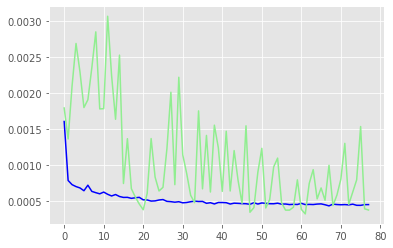

In [ ]:
# 輸入model參數
model = buildmodel(X_train.shape[1],X_train.shape[2],n1,n2,p)

# 進行訓練
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, y_train, epochs=150, batch_size = batch_size, validation_split=0.1, verbose=1, callbacks=[callback])
#, callbacks=[callback]
# 對訓練過程的損失函數繪圖
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'lightgreen')
#plt.savefig('第%d張損失函數圖.png'%(i+1))

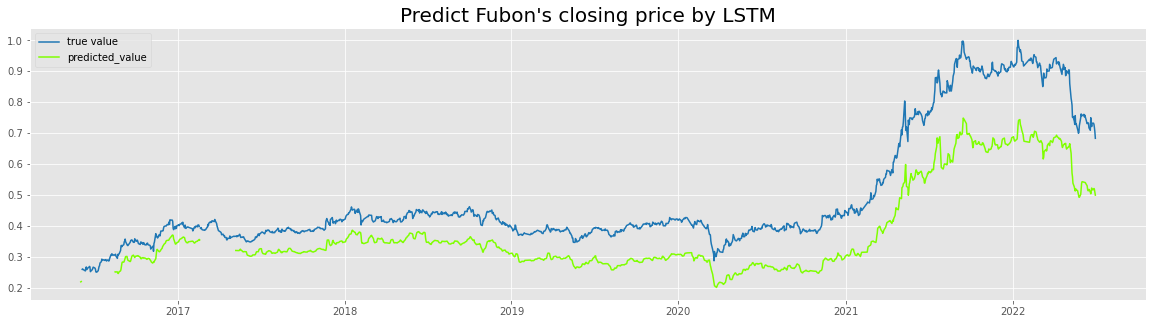

In [ ]:
# 產生預測值
predicted_value = model.predict(X_test)
plt.figure(figsize = (20,5))
test_date = date[len(train_data):]
plt.plot(test_date[-len(predicted_value):], y_test[-len(predicted_value):], label='true value',  color = '#1f77b4')
plt.plot(test_date[-len(predicted_value):], predicted_value, label='predicted_value',  color ='chartreuse')
plt.title("Predict Fubon's closing price by LSTM", fontsize=20)
plt.legend(loc='best')
plt.show()

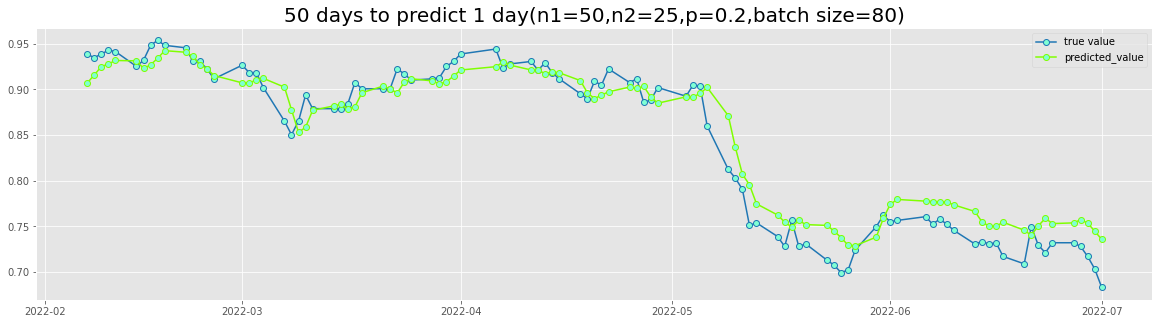

In [ ]:
# 產生預測值
predicted_value = model.predict(X_test)
plt.figure(figsize = (20,5))
test_date = date[len(train_data):]
plt.plot(test_date[-100:], y_test[-100:], label='true value',  color = '#1f77b4',\
         marker = 'o', mfc = 'aquamarine',mec = '#1f77b4', ms =6 )
diff = y_test[-70]-predicted_value[-70] #因會有空隙 所以找倒數第70個數重合
plt.plot(test_date[-100:], predicted_value[-100:]+diff, label='predicted_value',  color ='chartreuse'\
         , marker = 'o',mfc = 'aquamarine',mec ='chartreuse', ms =6)
plt.title("%s days to predict 1 day(n1=%s,n2=%s,p=%s,batch size=%s)"%(timesteps,n1,n2,p,batch_size), fontsize=20)
plt.legend(loc='best')
plt.show()

# For Loop

In [ ]:
n1 = [64, 128, 256]  #i
n2 = [64, 128, 256]  #j
p = 0.2
batch_size = [64, 128, 256] #k
timesteps = 20

n1 = [50]  #i
n2 = [25]  #j
p = 0.2
batch_size = [64] #k
timesteps = 20

In [ ]:
X_train, y_train = PrepData(train_data, timesteps, 1)
X_test, y_test = PrepData(test_data, timesteps, 1)

Epoch 1/150
50/50 [==============================] - 20s 83ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 2/150
50/50 [==============================] - 2s 42ms/step - loss: 5.3291e-04 - val_loss: 0.0018
Epoch 3/150
50/50 [==============================] - 2s 31ms/step - loss: 5.1901e-04 - val_loss: 0.0025
Epoch 4/150
50/50 [==============================] - 1s 26ms/step - loss: 5.1589e-04 - val_loss: 0.0021
Epoch 5/150
50/50 [==============================] - 2s 44ms/step - loss: 5.1588e-04 - val_loss: 0.0018
Epoch 6/150
50/50 [==============================] - 2s 46ms/step - loss: 5.1541e-04 - val_loss: 0.0034
Epoch 7/150
50/50 [==============================] - 3s 66ms/step - loss: 5.0414e-04 - val_loss: 0.0021
Epoch 8/150
50/50 [==============================] - 3s 62ms/step - loss: 4.9993e-04 - val_loss: 0.0017
Epoch 9/150
50/50 [==============================] - 2s 36ms/step - loss: 4.9625e-04 - val_loss: 0.0015
Epoch 10/150
50/50 [==============================] - 2s 30ms/step 

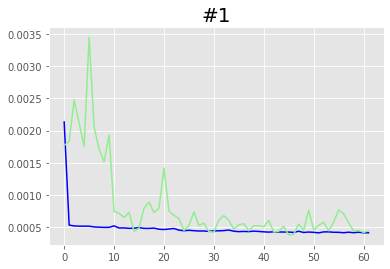

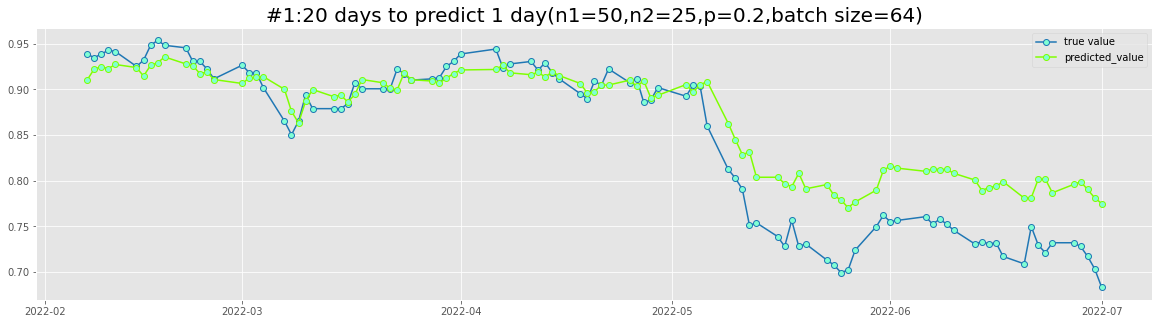

In [ ]:
for i in range(len(n1)):           #第一層神經元數i
  for j in range(len(n2)):         #第二層神經元數j
    for k in range(len(batch_size)):   #批次數量k

      # 輸入model參數
      model = buildmodel(X_train.shape[1], X_train.shape[2], n1[i], n2[j], p)

      # 進行訓練
      callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
      history = model.fit(X_train, y_train, epochs=150, batch_size = batch_size[k], validation_split=0.1, verbose=1, callbacks=[callback])
      #, callbacks=[callback]
      # 對訓練過程的損失函數繪圖
      plt.plot(history.history['loss'], 'b')
      plt.plot(history.history['val_loss'], 'lightgreen')
      plt.title("#%s"%(i*25+j*5+k+1), fontsize=20)
      #plt.savefig('第%d張損失函數圖.png'%(i*25+j*5+k+1))
      # 產生預測值
      predicted_value = model.predict(X_test)
      plt.figure(figsize = (20,5))
      test_date = date[len(train_data):]
      diff = y_test[-50]-predicted_value[-50]
      plt.plot(test_date[-100:], y_test[-100:], label='true value',  color = '#1f77b4',\
              marker = 'o', mfc = 'aquamarine',mec = '#1f77b4', ms =6 )
      plt.plot(test_date[-100:], predicted_value[-100:]+diff, label='predicted_value',  color ='chartreuse'\
              , marker = 'o',mfc = 'aquamarine',mec ='chartreuse', ms =6)
      plt.title("#%s:%s days to predict 1 day(n1=%s,n2=%s,p=%s,batch size=%s)"%(i*25+j*5+k+1,timesteps,n1[i],n2[j],p,batch_size[k]), fontsize=20)
      plt.legend(loc='best')
      #plt.savefig('第%d張預測圖.png'%(i+j+k+1))
      plt.show()

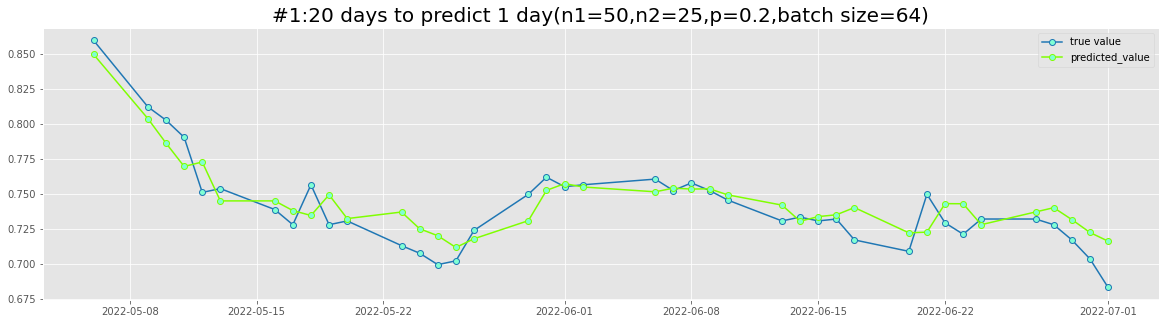

In [ ]:
plt.figure(figsize = (20,5))
test_date = date[len(train_data):]
plt.plot(test_date[-40:], y_test[-40:], label='true value',  color = '#1f77b4',\
         marker = 'o', mfc = 'aquamarine',mec = '#1f77b4', ms =6 )
plt.plot(test_date[-40:], predicted_value[-40:]+0.2, label='predicted_value',  color ='chartreuse'\
         , marker = 'o',mfc = 'aquamarine',mec ='chartreuse', ms =6)
plt.title("#%s:%s days to predict 1 day(n1=%s,n2=%s,p=%s,batch size=%s)"%(i*25+j*5+k+1,timesteps,n1[i],n2[j],p,batch_size[k]), fontsize=20)
plt.legend(loc='best')
plt.show()